In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
np_data = np.loadtxt("./data/Kissler_DataS1.csv", delimiter=",")
df_data = pd.DataFrame(np_data)
df_data.columns = ['Time', 'Person1', 'Person2', 'Distance']

g = nx.Graph()
for i in range(np_data.shape[0]):
    t, p1, p2, d = np_data[i]
    w = 1 * np.exp(-d/10.)
    if g.has_edge(p1, p2):
        g[p1][p2]['weight'] += w
    else:
        g.add_edge(p1, p2, weight=w)
        
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import networkx as nx

partition = community_louvain.best_partition(g)
# index i corresponding to node i + 1 that has partition p.
partition_array = []
for node, p in partition.items():
    partition_array.append(p)
# how many are in each partition
partition_numbers = {}
for node, p in partition.items():
    if p not in partition_numbers:
        partition_numbers[p] = 1
    else:
        partition_numbers[p] += 1
largest_partitions = sorted(partition_numbers, reverse=True, key=partition_numbers.get)[:5]


In [67]:
from enum import Enum

#1, 193, 385 = beginnings of days

# S = susceptible, E = exposed, I = infected, R = recovered
class State():
    S, E, I, R = range(4)
    
# Duration in timesteps before moving on to next state. (1 timestep = 5 minutes)
class Duration():
    E, I = 5, 572

class SEIR_Simulator:
    # Source: https://github.com/skissler/haslemere/blob/master/Kissler_SI.pdf
    
    def __init__(self, df):
        """
        Parameters and their values
        
        xi       Infection cutoff distance. d > xi -> no chance of infection.
        a        Value of F at d = 0
        rho      Value of F at d = 1/e
        
        n        Number of people
        maxtime  Maximum number of timesteps provided in simulation data
        """
        self.df = df.copy()
        self.df['Time'] = self.df['Time'] - 1
        self.df['Person1'] -= 1
        self.df['Person2'] -= 1
        
        # Force of infection parameters. F(d) = 0 if d > xi, and a * exp(d/rho) otherwise.
        
        self.xi = 20.0 
        # 
        self.a = 1.0
        # 
        self.rho = 10.0 
        
        self.n = int(df_data['Person2'].max())
        self.state = np.array([State.S] * self.n)
        self.partitions = np.array(partition_array)
        print(self.partitions)
        self.num_partitions = len(partition)
        

        self.timer = np.array([0] * self.n) # Countdown to move to next state.
        self.susceptible = np.array([True] * self.n)
        self.infectious = np.array([False] * self.n)
        
        # Create tdmatrix. tdmatrix[t,i,j] = distance between i and j at timestep t.
        self.maxtime = int(df_data['Time'].max())
        self.tdmatrix = np.zeros((self.maxtime, self.n, self.n))
        self.tdmatrix.fill(self.xi+1) # if no edge exists, set d > xi to simulate no contact.
        times = self.df['Time'].to_numpy().astype(int)
        p1s = self.df['Person1'].to_numpy().astype(int)
        p2s = self.df['Person2'].to_numpy().astype(int)
        distances = self.df['Distance'].to_numpy()
        coords = np.vstack([times, p1s, p2s]).T
        for i in range(coords.shape[0]):
            coord = coords[i]
            self.tdmatrix[coord[0], coord[1], coord[2]] = distances[i]
        
    def set_state(self, indices, s):
        if s == State.S:
            self.state[indices] = State.S
            self.susceptible[indices] = 1
            self.infectious[indices] = 0
        elif s == State.E:
            self.state[indices] = State.E
            self.timer[indices] = Duration.E
            self.susceptible[indices] = 0
            self.infectious[indices] = 0
        elif s == State.I:
            self.state[indices] = State.I
            self.timer[indices] = Duration.I
            self.susceptible[indices] = 0
            self.infectious[indices] = 1
        elif s == State.R:
            self.state[indices] = State.R
            self.susceptible[indices] = 0
            self.infectious[indices] = 0
            
    def infect_k_random(self, k):
        # Randomly infect k individuals.
        # This function assumes all individuals are currently not infected.
        indices = np.random.choice(np.arange(self.n), replace=False, size=k)
        self.set_state(indices, State.I)

    def probability_of_exposure_vectorized(self, t):
        currdists = self.tdmatrix[t]
        forcematrix = (currdists <= self.xi) * self.a * np.exp(-currdists / self.rho) * self.infectious
#         print(np.nonzero(forcematrix))
#         print(np.nonzero(self.infectious))
        probs = forcematrix.dot(np.ones(self.n)) * self.susceptible
        return probs
    
    def probability_of_exposure(self, i, t):
        if self.susceptible[i] == 0:
            return 0
        def force_of_infection(i, t):
            # Force of infection on individual i at timestep t.
            df = self.df
            df = df[df['Time'] == t] # Timestep t
            df_1 = df[(df['Person1'] == i)]
            df_2 = df[(df['Person2'] == i)]
            # Person i must be susceptible and the other person must be infectious
            infectious_1 = self.infectious[df_1['Person2'].to_numpy().astype(int)]
            df_1 = df_1['Distance'].to_numpy()
            df_1 = df_1[infectious_1]
            df_1 = df_1[df_1 <= self.xi]
            
            infectious_2 = self.infectious[df_2['Person1'].to_numpy().astype(int)]
            df_2 = df_2['Distance'].to_numpy() 
            df_2 = df_2[infectious_2]
            df_2 = df_2[df_2 <= self.xi]
            force = np.sum(self.a * np.exp(-np.concatenate([df_1, df_2]) / self.rho))
            return force
        return 1 - np.exp(-force_of_infection(i, t))
        
    def printSEIR(self, t):
            num_S = np.sum(self.state == State.S)
            num_E = np.sum(self.state == State.E)
            num_I = np.sum(self.state == State.I)
            num_R = np.sum(self.state == State.R)
            print(f"{t:4}: {num_S:4} {num_E:4} {num_I:4} {num_R:4}")
            
    def simulate(self, timesteps=576, logsteps=False):
        
        if logsteps == True:
            print(f"{'t':>4}: {'S':>4} {'E':>4} {'I':>4} {'R':>4}")
            print("===========================")
            self.printSEIR("init")
            
        # Initialize SEIR history
        S, E, I, R = [], [], [], []
        S_partition, E_partition, I_partition, R_partition = [], [], [], []
        
        for t in range(0, timesteps):
            
            tind = t % self.maxtime
            
            # S -> E
            exposed_probabilities = self.probability_of_exposure_vectorized(tind)
            p = np.random.random(self.n)
            transition_indices = p < exposed_probabilities
            self.set_state(transition_indices, State.E)
            
            # E -> I
            transition_indices = self.state == State.E
            transition_indices &= self.timer == 0
            self.set_state(transition_indices, State.I)
            
            # I -> R
            transition_indices = self.state == State.I
            transition_indices &= self.timer == 0
            self.set_state(transition_indices, State.R)
            
            # decrease timers
            self.timer = np.maximum(0, self.timer-1)
            
            if logsteps == True:
                self.printSEIR(t+1)
                
            S.append(np.sum(self.state == State.S))
            E.append(np.sum(self.state == State.E))
            I.append(np.sum(self.state == State.I))
            R.append(np.sum(self.state == State.R))
            
            #print([i for i, _ in enumerate(self.state == State.S)])
            #print(np.sum(np.logical_and(self.state==State.S, self.partitions == 1)))
            
            new_entry_S = []
            new_entry_E = []
            new_entry_I = []
            new_entry_R = []
            for partition in largest_partitions:
                new_entry_S.append(np.sum(np.logical_and(self.state==State.S, self.partitions == partition)))
                new_entry_E.append(np.sum(np.logical_and(self.state==State.E, self.partitions == partition)))
                new_entry_I.append(np.sum(np.logical_and(self.state==State.I, self.partitions == partition)))
                new_entry_R.append(np.sum(np.logical_and(self.state==State.R, self.partitions == partition)))

            S_partition.append(new_entry_S)
            E_partition.append(new_entry_E)
            I_partition.append(new_entry_I)
            R_partition.append(new_entry_R)


            """
            new_entry_S = []
            new_entry_E = []
            new_entry_I = []
            new_entry_R = []
            for i in range(1, self.num_partitions + 1):
                new_entry_S.append(self.partitions[node] == i for node in [self.state == State.S])
                new_entry_E.append(self.partitions[node] == i for node in [self.state == State.E])
                new_entry_I.append(self.partitions[node] == i for node in [self.state == State.I])
                new_entry_R.append(self.partitions[node] == i for node in [self.state == State.R])
            S_partition.append(new_entry_S)
            E_partition.append(new_entry_E)
            I_partition.append(new_entry_I)
            R_partition.append(new_entry_R)"""



        return S, E, I, R, S_partition, E_partition, I_partition, R_partition

[ 0  0  1  2  1  2  3  3  3  4  4  5  5  6  6  6  2  2  7  7  1  1  1  1
  8  8  8  9  1  1 10 10 10 10 10 10 11 10  2  2 12 13 12 10  6  6 14 14
 14 11 11 11 12 12 12  1  1  6 12 15 12 12 12 12 12 16 16 16 16 16 16 17
 17 16 18 11 18 19 19 20 10  6 21 21 22 22 22 13 13 19 19 12 12 20 20 23
 23 23  1 19  2  2 19 19 11 11 11 10 10 19 22 19 13 13 24 24 24 24  1  1
  1 13 13 13 21  9  9  9 25 25  0  0  0 15 15 15 11 11 11 11 21 21 19 19
 10 15 26 26 27 19 27 19  5  5  6  6 28 28 28 19 19 19 23 23 26 26  5  5
 21 21 29 29 15 15 30 30 30 10 10 13 13 13 19 19 19 19 19  3  3  3 16  1
 19 19 20 20 20 20 16 19  2  2 31 31 32 32 32 32 33 33 33 34 34 35 35 35
 36 36 36  0  0 15 15 15 16 16 16 12  9  5  5 37 37  9  9  9 38 38 34 34
 11  5 33  2  2 39 39  6  6 40 40 10 10  2  2 41 41  2 19 19  6  6  1  1
 21  1 17 27 11  1 33  1 15  1 19 11 19  1 16 20  1  2  2  1 32 19 11 19
 38 37 33 12 12  6  1 12  4 10 19 19 14  1 12  6 15  6  6 12 19 16 15  1
 12  6 21 21  1  9  1  9 33  1  1 19 27 13 21  0 12

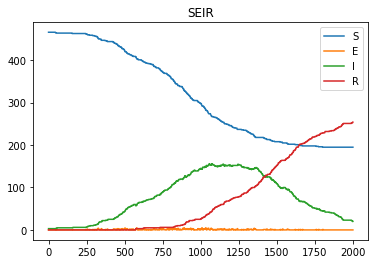

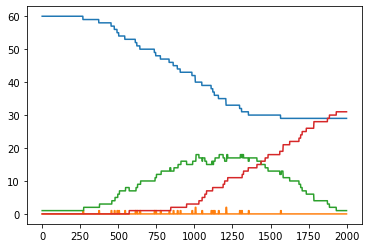

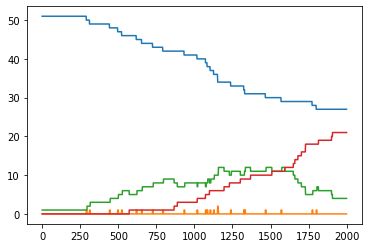

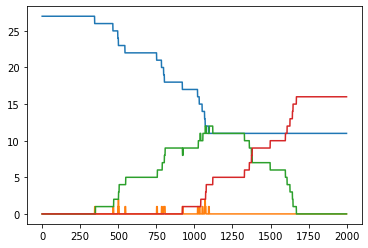

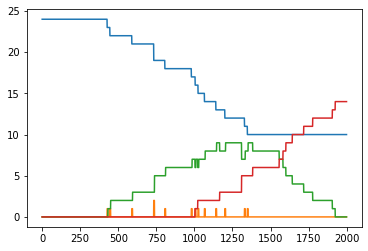

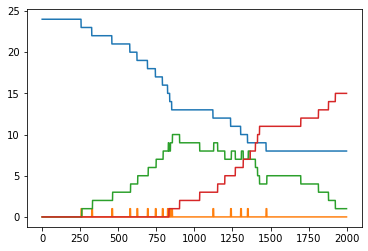

In [68]:
def plot_SEIR(S, E, I, R):
    steps = range(len(S))
    plt.figure()
    plt.title("SEIR")
    plt.plot(steps, S, label="S")
    plt.plot(steps, E, label="E")
    plt.plot(steps, I, label="I")
    plt.plot(steps, R, label="R")
    plt.legend()
    plt.show()

def plot_SEIR_Partitions(S_p, E_p, I_p, R_p):
    
    for i in range(len(largest_partitions)):
        plt.figure()
        steps = range(len(S_p))
        plt.plot(steps, [S[i] for S in S_p], label="S")
        plt.plot(steps, [E[i] for E in E_p], label="E")
        plt.plot(steps, [I[i] for I in I_p], label="I")
        plt.plot(steps, [R[i] for R in R_p], label="R")
        plt.show()
    
sim = SEIR_Simulator(df_data)
sim.infect_k_random(3)
results = sim.simulate(timesteps=2000, logsteps=False)
plot_SEIR(*results[:4])
plot_SEIR_Partitions(*results[-4:])


In [7]:
import sys
!{sys.executable} -m pip install python-louvain


  Using cached python-louvain-0.14.tar.gz (19 kB)
  Created wheel for python-louvain: filename=python_louvain-0.14-py3-none-any.whl size=9291 sha256=001354cf8c2edf6fc460b02699deb58be6246e5af5f9711b559cec66bb65ff45
  Stored in directory: /Users/kevinzhang/Library/Caches/pip/wheels/22/f9/ce/591ffa9b16851da50ca337c9ecfd44d79a7b87fcbd2a7a0021
Successfully built python-louvain


In [10]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx


NameError: name 'topg' is not defined